In [1]:
import itertools
import logging
from tqdm import tqdm_notebook
import unicodedata
import string

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_sequence, pad_sequence, pad_packed_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torch
import random

from collections import namedtuple
import numpy as np
import pdb

import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)

Batch = namedtuple("Batch", ["text", "labels"])

In [2]:
#### Partie traduction

PAD = 0
EOS = 1
SOS = 2
class VocabularyTrad:
    def __init__(self):
        self.word2id = {"<PAD>":PAD,"<EOS>":EOS,"<SOS>":SOS}
        self.id2word = {PAD:"<PAD>",EOS:"<EOS>",SOS:"<SOS>"}
    
    def get_sentence(self,sentence):
        return [self.get(x,True) for x in sentence.split(" ")]+[1]
    def get(self,w,adding=False):
        try:
            return self.word2id[w]
        except KeyError:
            if adding:
                self.word2id[w]=len(self.word2id)
                self.id2word[self.word2id[w]]=w
                return self.word2id[w]
            raise
    def __getitem__(self,i): return self.id2word[i]
    def __len__(self): return len(self.word2id)


def normalize(s):
    return ''.join(c if c in string.ascii_letters else " "
         for c in unicodedata.normalize('NFD', s.lower().strip()) 
         if  c in string.ascii_letters+" "+string.punctuation)



class TradDataset():
    def __init__(self,data,vocOrig,vocDest,adding=True,max_len=10):
        self.sentences =[]
        for s in tqdm_notebook(data.split("\n")):
            if len(s)<1:continue
            orig,dest=map(normalize,s.split("\t")[:2])
            if len(orig)>max_len: continue            
            self.sentences.append((torch.tensor(vocOrig.get_sentence(orig)),torch.tensor(vocDest.get_sentence(dest))))
    def __len__(self):return len(self.sentences)
    def __getitem__(self,i): return self.sentences[i]
    
    @staticmethod
    def collate(batch):
        data = [torch.Tensor(item[0].float()).long() for item in batch]
        labels = [torch.Tensor(item[1].float()).long() for item in batch]
        
        #return Batch(pack_sequence(data, enforce_sorted=True), pack_sequence(labels, enforce_sorted=True))
        return Batch(data, labels)


with open("kab-eng/kab.txt") as f:
    lines = f.read()
vocEngK = VocabularyTrad()
vocKab = VocabularyTrad()
datatrainK = TradDataset(lines,vocEngK,vocKab)


In [3]:
class Encoder(nn.Module):
    def __init__(self, orig_vocab_size, embed_size, hidden_size, n_layers=2):
        super(Encoder, self).__init__()
        self.orig_vocab_size = orig_vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding_layer = nn.Embedding(orig_vocab_size, embed_size)
        self.encode = nn.LSTM(embed_size, hidden_size, n_layers, bidirectional=False, batch_first=True)
        
        
        
    def forward(self, X):
        embeds = self.embedding_layer(X)
        outsEncoder, (hidden, cell) = self.encode(pack_sequence(embeds))
        
        """In case we have more than one layer lstm or bidirectional one"""
        context = hidden.transpose(0,1).contiguous().view(hidden.size(1),1,-1)
        cell = cell.transpose(0,1).contiguous().view(cell.size(1),1,-1)
        
        return context,cell

In [4]:
class Decoder(nn.Module):
    def __init__(self, dest_vocab_size, embed_size, hidden_size, n_layers=2):
        super(Decoder, self).__init__()
        
        self.dest_vocab_size = dest_vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding_layer = nn.Embedding(dest_vocab_size, embed_size)
        self.decoder_one_step = nn.LSTM(embed_size, hidden_size,n_layers, bidirectional=False, batch_first=True)
        self.project = nn.Linear(n_layers*hidden_size, dest_vocab_size)
        
    
    def forward(self, X, h_c_tuple):
        """X.size(): batch*1"""
        h,c=h_c_tuple
        X=X.unsqueeze(1)
        embed = self.embedding_layer(X)
        #print("***",h.shape, c.shape)
        outputs, (hidden, cell) = self.decoder_one_step(embed,(h,c))
        #print(hidden.shape)
        y_hat = self.project(hidden)
        #print(y_hat.shape)
        return y_hat, (hidden.transpose(0,1), cell.transpose(0,1))

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, X_src, X_target, constrained_mode_prob=0.3, train=True):
        
        #pdb.set_trace()
        #print(len(X))
        #pdb.set_trace()
        X_src=pad_sequence(X_src, batch_first=True, padding_value=PAD).long()
        X_target=pad_sequence(X_target, batch_first=False, padding_value=PAD).long()
        
        trg_len = X_target.size(0) 
        """Batch size"""
        hiddens,cells = self.encoder(X_src)    
        
        batch_size = hiddens.size(0)
        """Decoder"""
        
        #print(":::::",hiddens.shape, cells.shape)
        
        X = torch.Tensor([SOS]*batch_size).long()
        
        if train:
            
            outputs = torch.zeros(trg_len, batch_size, self.decoder.dest_vocab_size)
            for i in range(trg_len):
                X, (hiddens, cells) = self.decoder(X,(hiddens.transpose(0,1),cells.transpose(0,1)))

                outputs[i]=X.squeeze(0)

                constraint = random.random() < constrained_mode_prob
                if constraint:
                    X = X_target[i]
                else:
                    X = X.argmax(2).squeeze(0)
        else:
            i=0
            outputs=[]
            while X.item()!=EOS:
                
                X, (hiddens, cells) = self.decoder(X,(hiddens.transpose(0,1),cells.transpose(0,1)))

                outputs.append(X.squeeze(0))
                X = X.argmax(2).squeeze(0)
            
        return outputs

In [8]:
batch_size=128

embed_size_encoder=256
embed_size_decoder=256

hidden_dim_encoder=512

hidden_dim_decoder=hidden_dim_encoder

orig_vocab_size=len(vocEngK.word2id)
dest_vocab_size=len(vocKab.word2id)

dataLoaderTrainK = DataLoader(datatrainK, batch_size=batch_size, collate_fn=datatrainK.collate)

encoderModel = Encoder(orig_vocab_size, embed_size_encoder, hidden_dim_encoder, n_layers=1)
decoderModel = Decoder(dest_vocab_size, embed_size_decoder,hidden_dim_decoder, n_layers=1)
seq2seqModel = Seq2Seq(encoderModel, decoderModel)

lr=0.0001
optimizer = optim.Adam(list(seq2seqModel.parameters())+list(encoderModel.parameters())+list(decoderModel.parameters()),lr=lr)

criterion = nn.CrossEntropyLoss(ignore_index=PAD)

nb_epoch = 300
clip = 1

constrained_mode_prob = 0.9

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(seq2seqModel):,} trainable parameters')

The model has 3,751,082 trainable parameters


In [9]:
list_errors = []
for epoch in tqdm_notebook(range(nb_epoch)):
    epoch_error = 0
    for x,y in dataLoaderTrainK:

        optimizer.zero_grad()
        outputs=seq2seqModel(x,y, constrained_mode_prob=0.8, train=True)
        
        y=pad_sequence(y).view(-1)
        outputs=outputs.view(-1,outputs.shape[-1])
        loss = criterion(outputs, y)
        loss.backward()
        
        list_errors.append(loss.item())
        #torch.nn.utils.clip_grad_norm_(seq2seqModel.parameters(), clip)
        optimizer.step()
        
        epoch_error+=loss.item()
        if epoch%10 == 0:
            constrained_mode_prob*=constrained_mode_prob
        
    #print(epoch_error/len(dataLoaderTrain))
    #list_errors.append(epoch_error/len(dataLoaderTrain))
    

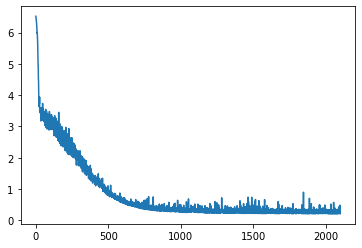

In [10]:
plt.plot(list_errors)

In [11]:
seq2seqModel=seq2seqModel.eval()

In [33]:
x,y=datatrainK.__getitem__(200)
for word in x:
    print(vocEngK.id2word[word.item()])

for word in y:
    print(vocKab.id2word[word.item()])


stop
it

<EOS>
hbes
it

<EOS>


In [15]:
def translate(model, sentence, vocOri, vocDest):
    #pdb.set_trace()
    sentence_ids = torch.Tensor(vocOri.get_sentence(sentence)).long().unsqueeze(0)
    y_hat = model(sentence_ids,sentence_ids, 0, False)
    
    sentence_target = ""
    for word in y_hat:
        sentence_target+=vocDest.id2word[word.argmax(1).item()]+" "
    print("Sentence origin:{}\nSentence target:{}".format(sentence, sentence_target))

In [42]:
sentence = "take it"
translate(seq2seqModel, sentence, vocEngK, vocKab)

Sentence origin:take it
Sentence target:ddem it  <EOS> 


In [17]:
torch.save(seq2seqModel.state_dict(), "./modelEngKab")